# 0. Preparation

In [1]:
if 'google.colab' in str(get_ipython()):
    IN_COLLAB = True
else:
    IN_COLLAB = False

if IN_COLLAB:
    #TODO: CHANGE THIS BASED ON YOUR OWN LOCAL SETTINGS
    MY_HOME_ABS_PATH = "/content/drive/MyDrive/W210/co2-flux-hourly-gpp-modeling"
    from google.colab import drive
    drive.mount('/content/drive/')
else:
    MY_HOME_ABS_PATH = "/root/co2-flux-hourly-gpp-modeling/"

## Import libraries

# Load data from Azure blob

In [4]:
root_dir =  MY_HOME_ABS_PATH
tmp_dir =  root_dir + os.sep + '.tmp'
model_dir = root_dir + os.sep + 'data' + os.sep + 'models'
cred_dir = root_dir + os.sep + '.cred'
az_cred_file = cred_dir + os.sep + 'azblobcred.json'

# Download full data
container = "all-sites-data"
blob_name = "full_2010_2015_v_mvp_raw.parquet"

data_df = get_raw_datasets(container, blob_name)

Data size: (4862712, 51)
Data Columns: Index(['GPP_NT_VUT_REF', 'site_id', 'timestep_idx_local',
       'timestep_idx_global', 'datetime', 'date', 'year', 'month', 'day',
       'hour', 'TA_ERA', 'SW_IN_ERA', 'LW_IN_ERA', 'VPD_ERA', 'P_ERA',
       'PA_ERA', 'EVI', 'NDVI', 'NIRv', 'b1', 'b2', 'b3', 'b4', 'b5', 'b6',
       'b7', 'IGBP', 'lat', 'long', 'koppen_sub', 'koppen_main', 'c3c4',
       'c4_percent', 'BESS-PAR', 'BESS-PARdiff', 'BESS-RSDN', 'CSIF-SIFdaily',
       'PET', 'Ts', 'ESACCI-sm', 'MODIS_LC', 'NDWI', 'Percent_Snow', 'Fpar',
       'Lai', 'LST_Day', 'LST_Night', 'MODIS_IGBP', 'MODIS_PFT',
       'gap_flag_hour', 'gap_flag_month'],
      dtype='object')
NA count: 0


# Eval Model

In [5]:
model_dir = "tft_model_14_2_5YrTrain_7DEncode_SmallNetwork_TopFeatures_NoGPP_230402_2258"
exp_model_dir = f"/root/co2-flux-hourly-gpp-modeling/data/models/{model_dir}"
checkpt_dir = f"{exp_model_dir}/lightning_logs/version_0/checkpoints/"
checkpt = os.listdir(checkpt_dir)[-1]
best_model_path = f"{checkpt_dir}{checkpt}"
print(f"Best model: {checkpt}")

Best model: epoch=3-step=10024.ckpt


In [6]:
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)
print(f"Quantiles: {best_tft.loss.quantiles}") # [0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98]

# Experiment constants
VAL_INDEX  = 3
TEST_INDEX = 4
SUBSET_LEN = 24*365*5
ENCODER_LEN = 24*7   # 7 days
print(f"Training timestemp length = {SUBSET_LEN}.")

# create dataloaders for model
# ref: https://pytorch-lightning.readthedocs.io/en/stable/guides/speed.html#dataloaders
batch_size = 256  # set this between 32 to 128
cpu_count = os.cpu_count()

Quantiles: [0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98]
Training timestemp length = 43800.


In [ ]:
def get_eval_metrics_simple(y_true, y_pred, mask=None):    
    # Apply mask if there is any
    if mask is not None:            
        y_true = y_true[mask.bool()]
        y_pred = y_pred[mask.bool()]

    rmse = torch.sqrt(torch.mean((y_true - y_pred) ** 2)).item()
    mae = torch.mean((y_true - y_pred).abs()).item()
    nse = nash_sutcliffe(y_true, y_pred).item()
    
    return rmse, mae, nse

def eval_raw_preds(raw_preds, val_dl):
    # Format val_preds
    val_preds = raw_preds['prediction'][:, :, 3]
    
    # Get actuals and mask from val_dl
    val_actuals_list = []
    mask_list = []
    for x, y in iter(val_dl):
        val_actuals_list.append(y[0])
        mask_list.append(x['x_cat'][-1, -1].reshape(-1))
    val_actuals = torch.cat(val_actuals_list)
    mask = torch.logical_not(torch.cat(mask_list))

    # Reshape
    val_actuals = val_actuals.reshape(-1)
    val_preds = val_preds.reshape(-1)

    # Masked eval
    masked_eval_metric = get_eval_metrics_simple(val_actuals, val_preds, mask)
    
    return masked_eval_metric
    
    
rmse, mae, nse = eval_raw_preds(raw_prediction_site, validation.filter(lambda x: (x.site_id == choose_site)))

In [7]:
def setup_tsdataset_nogpp_slim(train_df, val_df, test_df, min_encoder_len):
    training = TimeSeriesDataSet(
      train_df,
      time_idx="timestep_idx_global",
      target="GPP_NT_VUT_REF",
      group_ids=["site_id"],
      allow_missing_timesteps=False,
      min_encoder_length=min_encoder_len,
      max_encoder_length=min_encoder_len,
      min_prediction_length=1,
      max_prediction_length=1,
      static_categoricals=["MODIS_IGBP","koppen_main"],
      static_reals=[],
      time_varying_known_categoricals=["month", "hour"],
      time_varying_known_reals=['TA_ERA', 'SW_IN_ERA', 'LW_IN_ERA', 'VPD_ERA', 'P_ERA', 'PA_ERA',
                                'EVI', 'NDVI', 'NIRv', 'BESS-RSDN',],
      time_varying_unknown_categoricals=["gap_flag_month", "gap_flag_hour"], 
      time_varying_unknown_reals=[],
      target_normalizer=None,
      categorical_encoders={'MODIS_IGBP': NaNLabelEncoder(add_nan=True),
                            'koppen_main': NaNLabelEncoder(add_nan=True),
                            },
      add_relative_time_idx=True,
      add_target_scales=False,
      add_encoder_length=False,
    )

    validation = TimeSeriesDataSet.from_dataset(training, val_df, predict=False, stop_randomization=True)
    
    if test_df is not None:
        testing = TimeSeriesDataSet.from_dataset(training, test_df, predict=False, stop_randomization=True)
    else:
        testing = None

    return (training, validation, testing)


In [8]:
# Setup dataset
train_df, val_df, _ = get_splited_datasets(data_df, VAL_INDEX, TEST_INDEX)
train_df, val_df, _ = subset_data(train_df, val_df, None, SUBSET_LEN)
train, validation, _ = setup_tsdataset_nogpp_slim(train_df, val_df, None, ENCODER_LEN)

Subest length: 43800 timesteps for each sites
Subset num train timesteps: 2579424
Subset num val timesteps: 952752


# Model Interpretation

In [39]:
# # ## TEMP FOR DEV
# val_df_sub = val_df.loc[val_df['site_id'] == 'AU-DaP', ].copy()
# train, validation, _ = setup_tsdataset_nogpp_slim(train_df, val_df_sub, None, ENCODER_LEN)

In [9]:
# Get standard preds
predictions = best_tft.predict(validation, show_progress_bar=False)

# Get raw preds with additional info
raw_predictions, x = best_tft.predict(validation, mode="raw", return_x=True, show_progress_bar=False)

# Get actuals
actuals = torch.cat([y for x, (y, weight) in iter(validation)])

### Get overall interpretation

In [96]:
# Get aveage feature importances into dictionary
feature_imps = torch.mean(raw_predictions['encoder_variables'], dim=0).squeeze()
avg_fi_vals = ['Average'] + list(torch.mean(feature_imps, dim=0).numpy())

### Plot examples

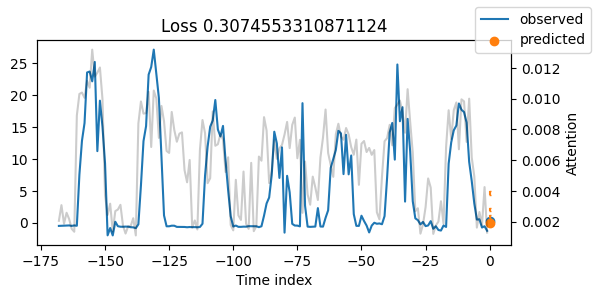

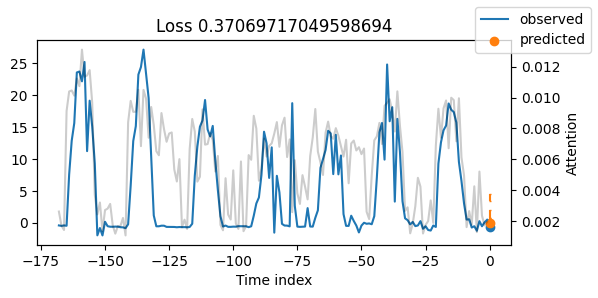

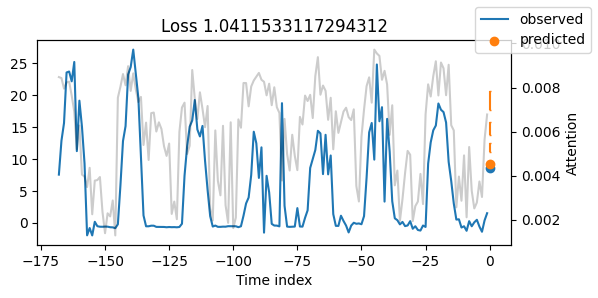

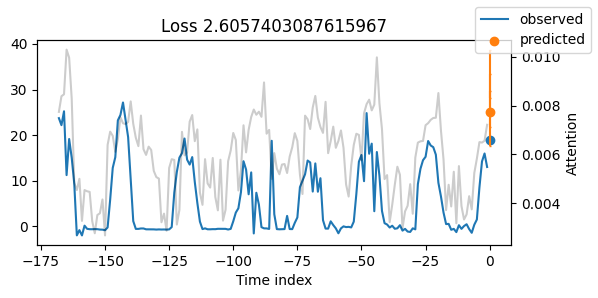

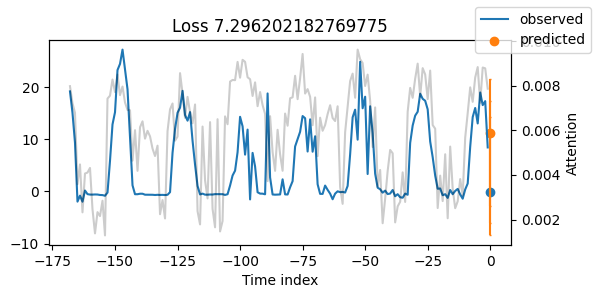

In [11]:
num_ex = 5
for idx in range(num_ex):
    best_tft.plot_prediction(x, raw_predictions, idx=idx*4, add_loss_to_title=True);

### Plot worst examples

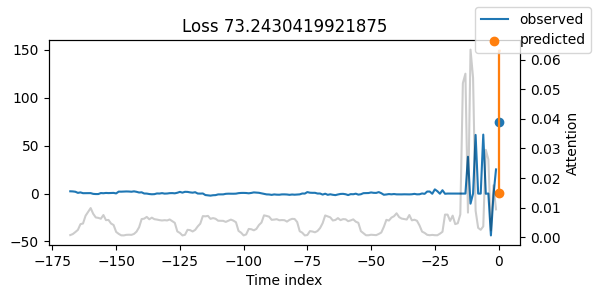

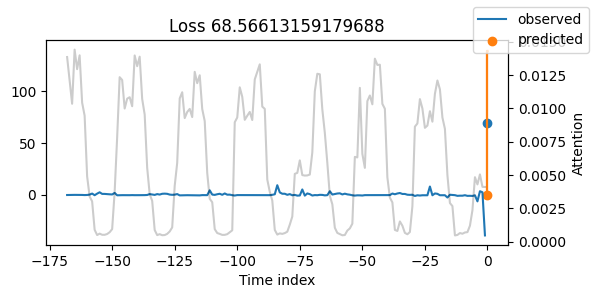

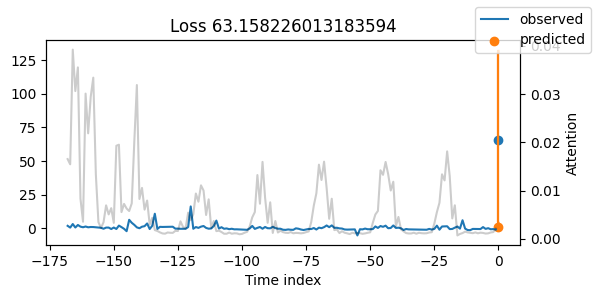

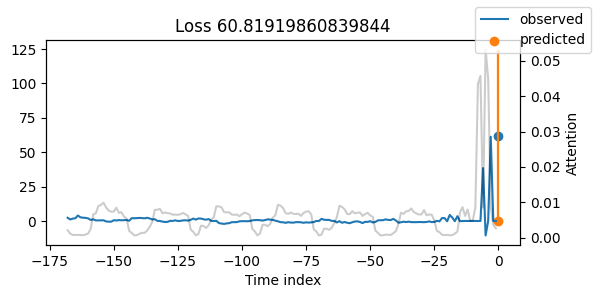

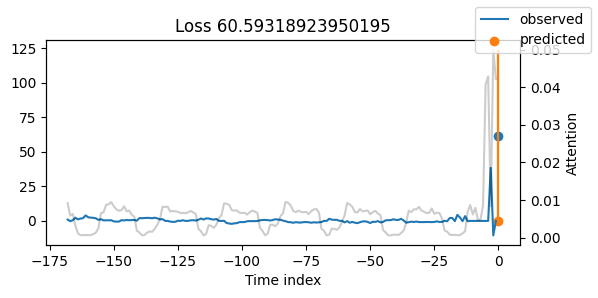

In [12]:
# Find worst RMSE scores in val set
num_bad_ex = 5
mean_losses = RMSE(reduction="none")(predictions, actuals.reshape(-1, 1)).mean(1)
indices = mean_losses.argsort(descending=True)  # sort losses
for idx in range(num_bad_ex):  # plot 10 examples
    best_tft.plot_prediction(
        x, raw_predictions, idx=indices[idx], add_loss_to_title=True);

## Plot best examples

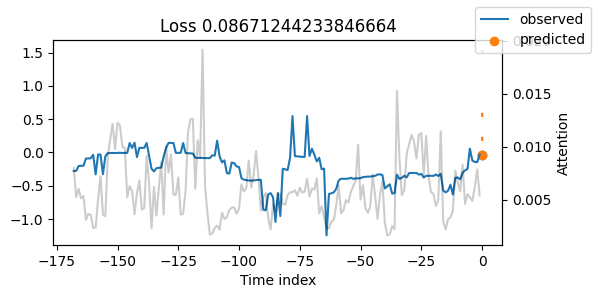

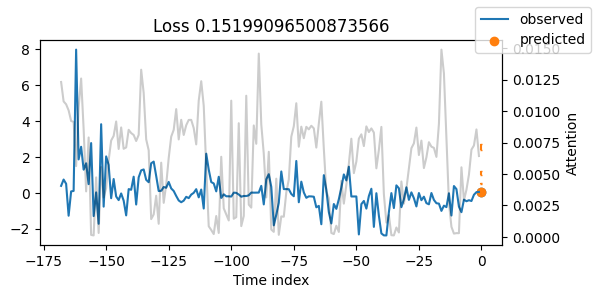

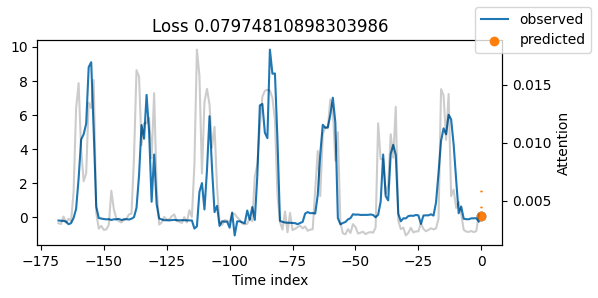

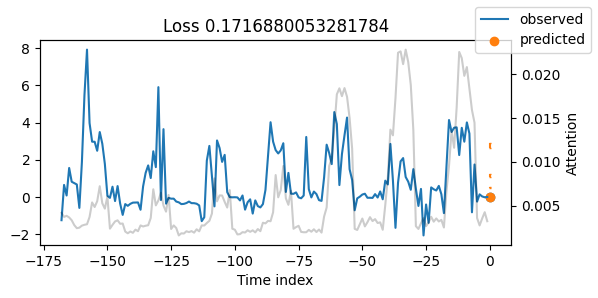

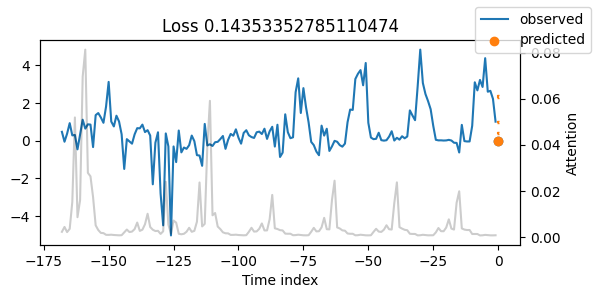

In [13]:
indices = mean_losses.argsort(descending=False)  # sort losses
for idx in range(num_bad_ex):  # plot 10 examples
    best_tft.plot_prediction(
        x, raw_predictions, idx=indices[idx], add_loss_to_title=True);

## Get sequence of preds for each timestep vs actuals
To-Do: Make so that we can identify specific sites and specific times

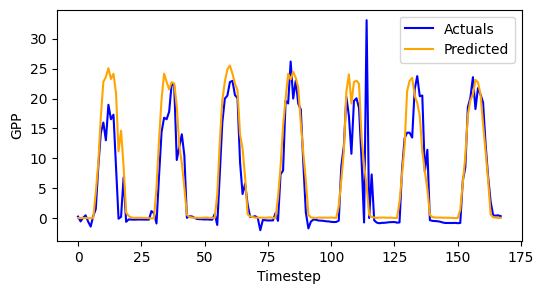

In [14]:
# Choose num hours to plot
plot_x_steps = 24*7
x_ticks = np.arange(plot_x_steps)

# Create the line plot
plt.plot(x_ticks, actuals[:plot_x_steps], color='blue', label='Actuals')
plt.plot(x_ticks, predictions[:plot_x_steps], color='orange', label='Predicted')

# Add labels and legend
plt.xlabel('Timestep')
plt.ylabel('GPP')
plt.legend()

# Show the plot
plt.show()

## Plot predictions by variable

In [ ]:
# train_preds, x_train = best_tft.predict(train, return_x=True, show_progress_bar=False)
# predictions_vs_actuals = best_tft.calculate_prediction_actual_by_variable(x_train, train_preds)
# best_tft.plot_prediction_actual_by_variable(predictions_vs_actuals);

## Plot predictions by IGBP
To-Do: Get eval metrics by IGBP

In [15]:
known_cat=["month", "hour"]
known_real=['TA_ERA', 'SW_IN_ERA', 'LW_IN_ERA', 'VPD_ERA', 'P_ERA', 'PA_ERA', 'EVI', 'NDVI', 'NIRv', 'BESS-RSDN']
unknown_cat=["gap_flag_month", "gap_flag_hour"]

In [16]:
def get_feature_imps_group(raw_preds, df, group_name):
    # Get mean values
    time_means = torch.mean(raw_preds['encoder_variables'], dim=0).squeeze()
    vals = [group_name] + list(torch.mean(time_means, dim=0).numpy())
    
    # Append to df
    df.loc[len(df)] = vals
    
    return df


IGBP: CRO

IGBP: DBF

IGBP: EBF


,IGBP,month,hour,gap_flag_month,gap_flag_hour,TA_ERA,SW_IN_ERA,LW_IN_ERA,VPD_ERA,P_ERA,PA_ERA,EVI,NDVI,NIRv,BESS-RSDN,relative_time_idx
0,CRO,0.02803,0.04709,0.04481,0.19412,0.05461,0.08531,0.06929,0.06427,0.01375,0.07529,0.12962,0.06953,0.03467,0.07595,0.01367
1,DBF,0.02690,0.04858,0.04394,0.22816,0.06935,0.07944,0.05101,0.08491,0.01314,0.05546,0.15184,0.05707,0.01758,0.05462,0.01799
2,EBF,0.00949,0.03269,0.02132,0.14232,0.28147,0.07120,0.04079,0.03679,0.03444,0.03920,0.04447,0.06737,0.06951,0.04108,0.06786


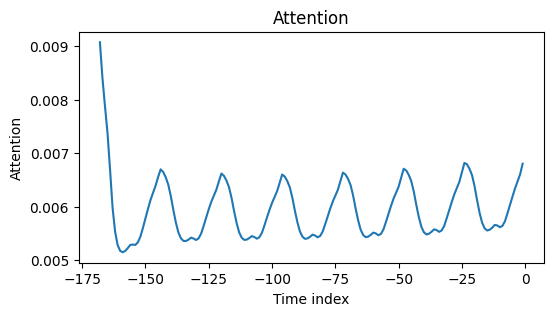

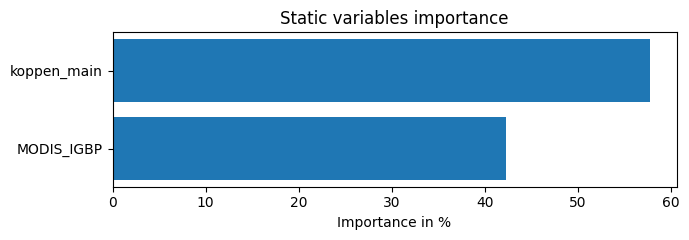

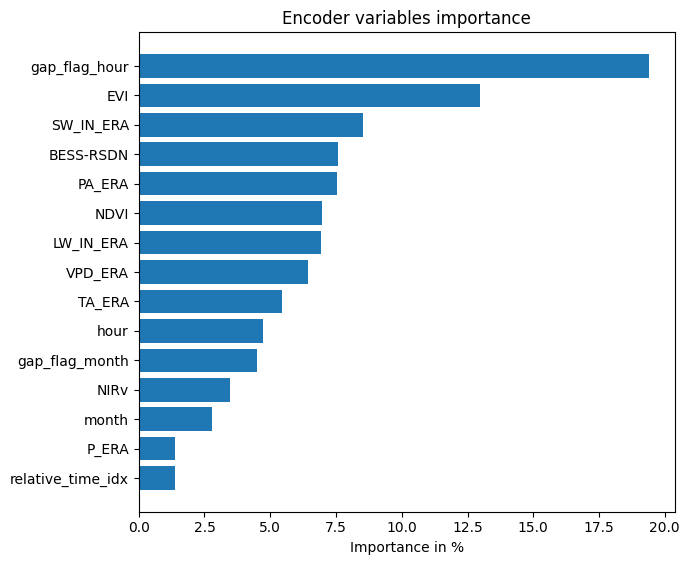

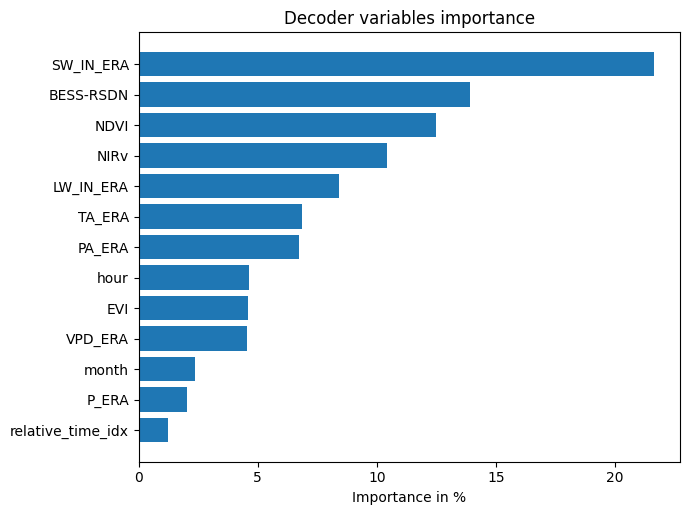

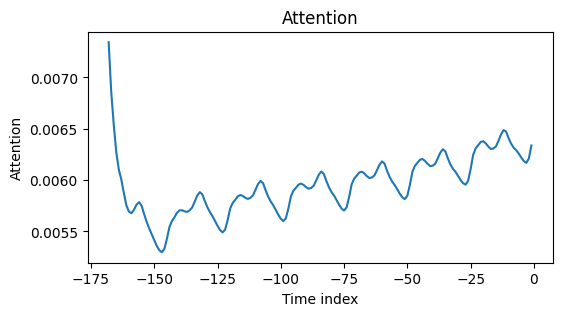

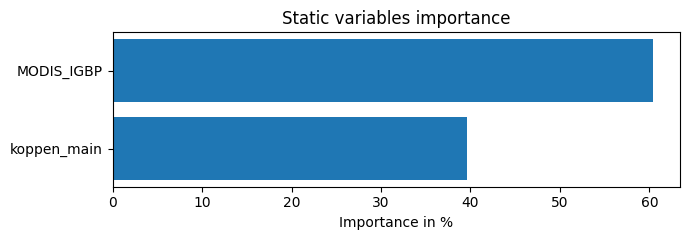

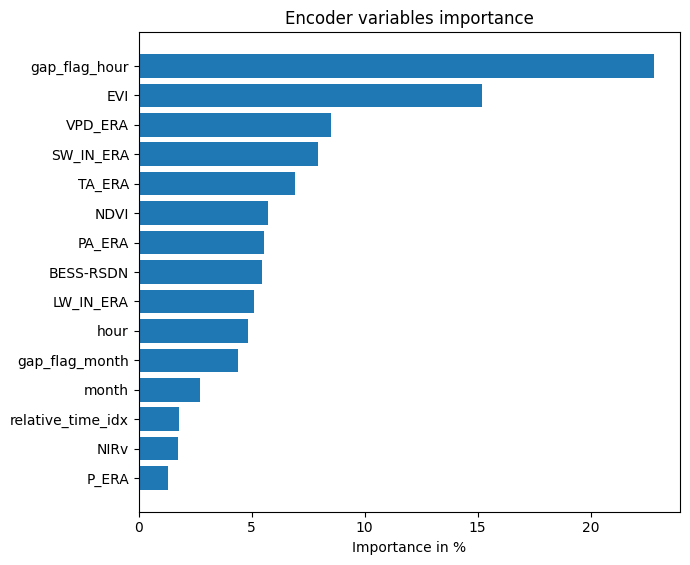

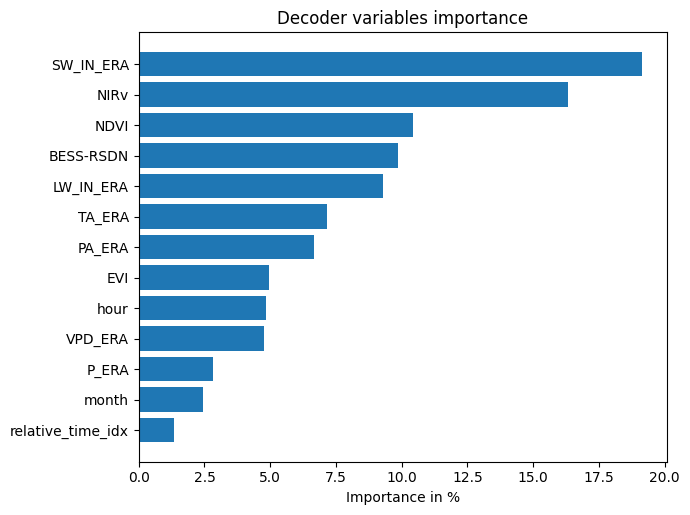

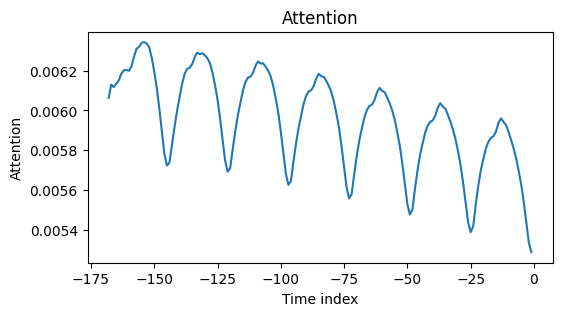

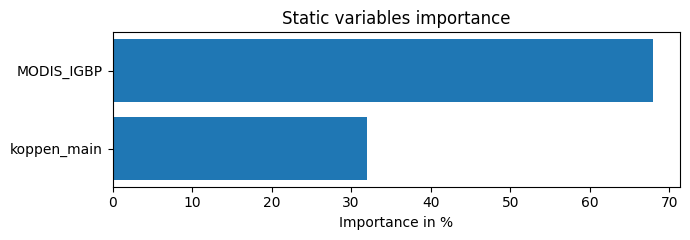

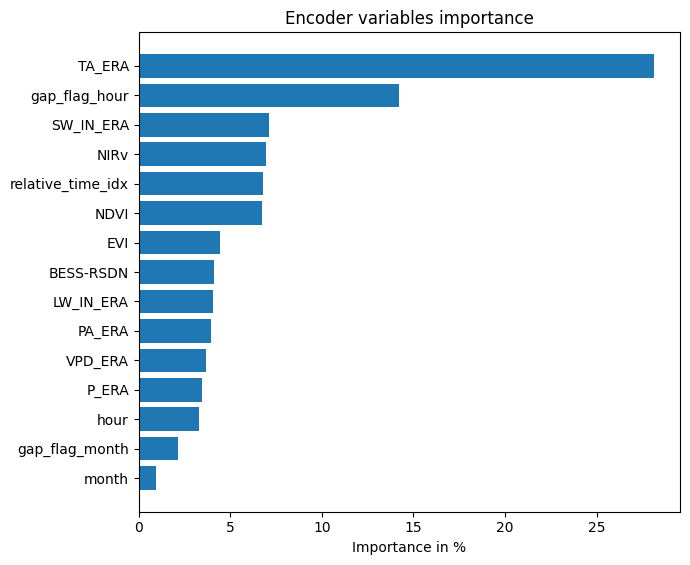

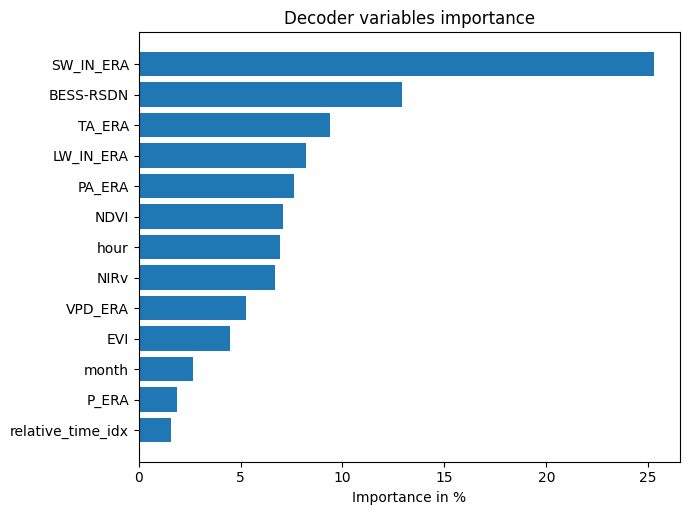

In [17]:
i = 0
igbp_groups = val_df.groupby('IGBP')
igbp_fi_df = pd.DataFrame(columns= ['IGBP'] + known_cat + unknown_cat + known_real + ['relative_time_idx'])

# Add avg importances to df
igbp_fi_df.loc[len(igbp_fi_df)] = avg_fi_vals

# Loop through each group and print the mean "value"
for group_name, group_df in igbp_groups:
    print(f"\nIGBP: {group_name}")
    _, val_igbp, _ = setup_tsdataset_nogpp_slim(train_df, group_df, None, ENCODER_LEN)
    raw_prediction_igbp = best_tft.predict(val_igbp, mode="raw", return_x=False, show_progress_bar=False)
        
    # Interpret Outputs
    interpretation_sum = best_tft.interpret_output(raw_prediction_igbp, reduction="sum")
    best_tft.plot_interpretation(interpretation_sum)
    
    # Append feature imps to df
    igbp_fi_df = get_feature_imps_group(raw_prediction_igbp, igbp_fi_df, group_name)
    
    # Temp break to test a few example IGBPs
    i +=1
    if i == 3:
        break
        
igbp_fi_df.head()

## Plot predictions by site

In [109]:
## Goal: Get performance metrics by site -> find the best and worst sites -> analyze attention, feature importances
# Init df
site_metric_df = pd.DataFrame(columns=['site_id', 'rmse', 'mae', 'nse'])

# Create single df with preds, actuals and site info
val_dec_df = pd.DataFrame(validation.decoded_index)
val_dec_df['preds'] = raw_predictions['prediction'].squeeze()[:, 3]
val_dec_df['actuals'] = torch.cat([y[0] for x, y in iter(validation)]).reshape(-1)

# Loop through sites and get site-level metrics
print("Begin loop")
for name, group in tqdm(val_dec_df.groupby('site_id')):
    y_pred  = torch.tensor(group['preds'].values)
    y_true = torch.tensor(group['actuals'].values)
    
    # Metrics
    rmse = torch.sqrt(torch.mean((y_true - y_pred) ** 2)).item()
    mae = torch.mean((y_true - y_pred).abs()).item()
    nse = nash_sutcliffe(y_true, y_pred).item()
    
    # Append
    site_metric_df.loc[len(site_metric_df)] = [name, rmse, mae, nse]

Begin loop


100%|██████████| 26/26 [00:00<00:00, 287.69it/s]


In [113]:
site_metric_df.sort_values('nse', ascending=False, inplace=True)
print(len(site_metric_df))
display(site_metric_df.head(3))

site_metric_df.sort_values('nse', ascending=True, inplace=True)
display(site_metric_df.head(3))

26


,site_id,rmse,mae,nse
14,GF-Guy,3.13896,2.31137,0.91769
20,US-Bar,2.51825,1.39172,0.84821
9,DE-Hai,3.24677,1.71343,0.82571


,site_id,rmse,mae,nse
1,AU-Emr,3.09904,1.86409,-0.34186
22,US-Mpj,2.45073,1.67736,-0.28903
17,SE-Deg,1.42421,0.85326,0.10350


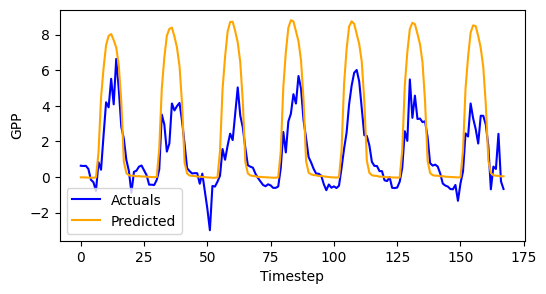

In [117]:
# Site actuals
site_preds = val_dec_df.loc[val_dec_df['site_id']==choose_site, ].copy()

# Choose num hours to plot
plot_x_steps = 24*7
x_ticks = np.arange(plot_x_steps)
plt.plot(x_ticks, site_preds['actuals'].values[:plot_x_steps], color='blue', label='Actuals')
plt.plot(x_ticks, site_preds['preds'].values[:plot_x_steps], color='orange', label='Predicted')
plt.xlabel('Timestep')
plt.ylabel('GPP')
plt.legend()
plt.show()

Site: GF-Guy


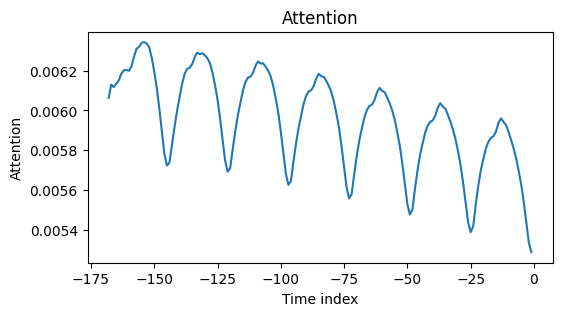

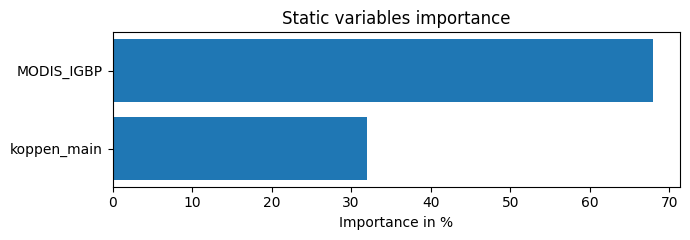

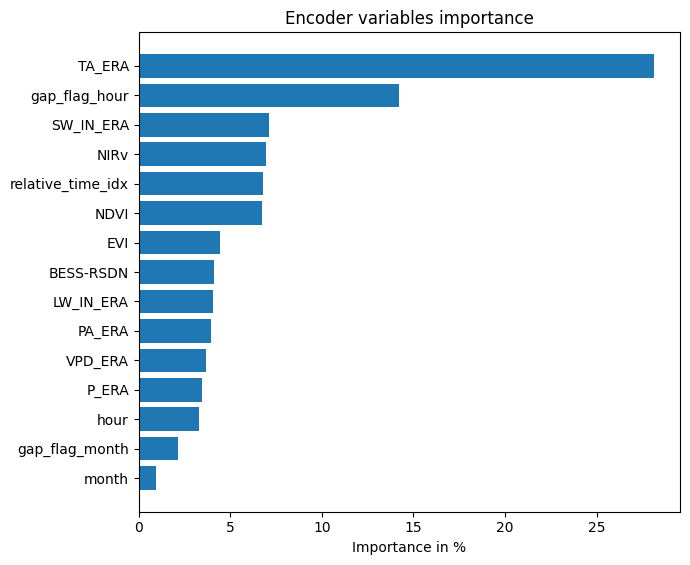

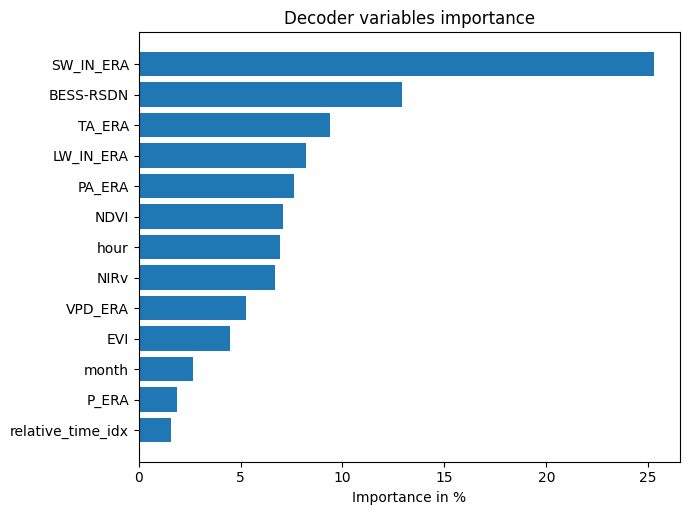

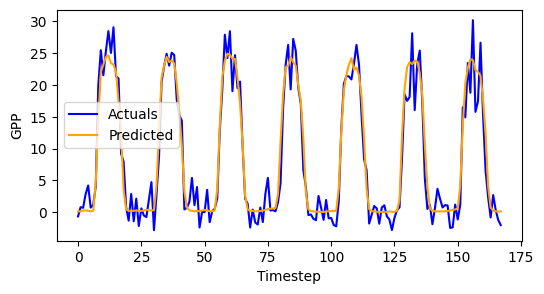

Site: AU-Emr


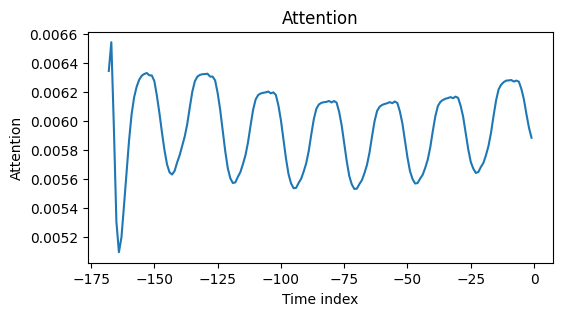

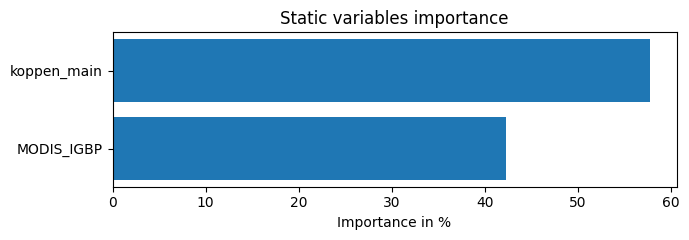

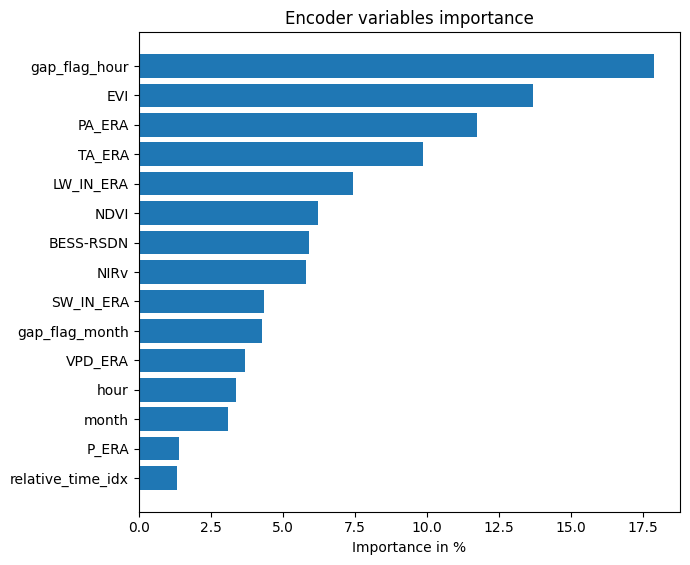

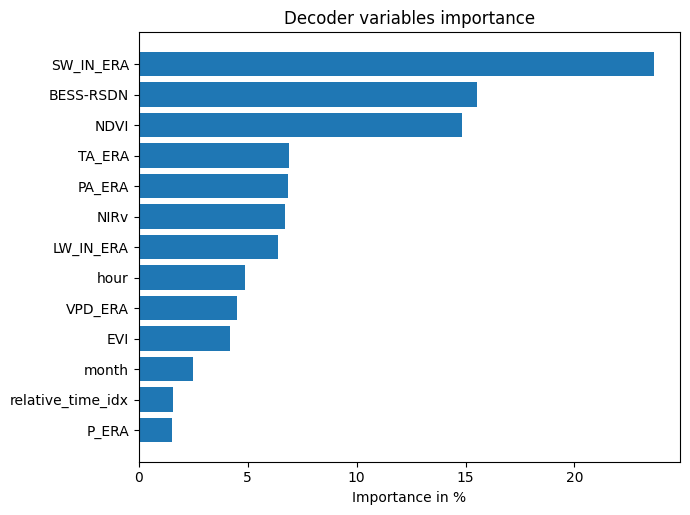

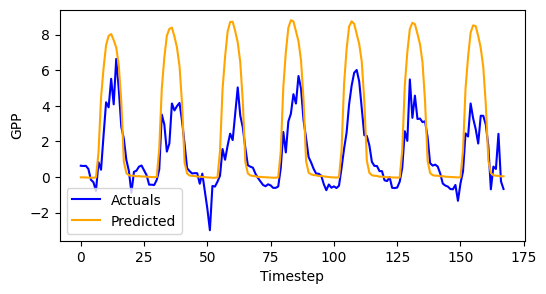

Site: US-Mpj


,site_id,month,hour,gap_flag_month,gap_flag_hour,TA_ERA,SW_IN_ERA,LW_IN_ERA,VPD_ERA,P_ERA,PA_ERA,EVI,NDVI,NIRv,BESS-RSDN,relative_time_idx
0,Average,0.03011,0.03660,0.06451,0.17843,0.09800,0.07457,0.05644,0.05134,0.05122,0.06304,0.11954,0.06280,0.04373,0.05006,0.01962
1,GF-Guy,0.00949,0.03269,0.02132,0.14232,0.28147,0.07120,0.04079,0.03679,0.03444,0.03920,0.04447,0.06737,0.06951,0.04108,0.06786
2,AU-Emr,0.03101,0.03369,0.04268,0.17880,0.09865,0.04352,0.07436,0.03700,0.01408,0.11734,0.13668,0.06212,0.05793,0.05897,0.01317
3,US-Mpj,0.02307,0.01655,0.13098,0.17430,0.02940,0.04582,0.04577,0.03810,0.24732,0.03621,0.07219,0.03147,0.05065,0.03916,0.01903


In [120]:
# Init Hour Feature Importance DF
site_fi_df = pd.DataFrame(columns= ['site_id'] + known_cat + unknown_cat + known_real + ['relative_time_idx'])
site_fi_df.loc[len(site_fi_df)] = avg_fi_vals

i = 0
val_sites = ['GF-Guy', 'AU-Emr', 'US-Mpj']
for choose_site in val_sites:
    print(f"Site: {choose_site}")
    
    # Get preds for the given hour of day
    raw_prediction_site = best_tft.predict(
        validation.filter(lambda x: (x.site_id == choose_site)),
        mode="raw",
        return_x=False)
    
    # Interpret Outputs
    i += 1
    if i < 3:
        interpretation_sum = best_tft.interpret_output(raw_prediction_site, reduction="sum")
        best_tft.plot_interpretation(interpretation_sum)
        plt.show(block=False)
        
        # Plot preds vs actuals
        site_preds = val_dec_df.loc[val_dec_df['site_id']==choose_site, ].copy()

        # Choose num hours to plot
        plot_x_steps = 24*7
        x_ticks = np.arange(plot_x_steps)
        plt.plot(x_ticks, site_preds['actuals'].values[:plot_x_steps], color='blue', label='Actuals')
        plt.plot(x_ticks, site_preds['preds'].values[:plot_x_steps], color='orange', label='Predicted')
        plt.xlabel('Timestep')
        plt.ylabel('GPP')
        plt.legend()
        plt.show()
    
    # Append Feature Importances to DF
    site_fi_df = get_feature_imps_group(raw_prediction_site, site_fi_df, choose_site)
    

site_fi_df.head()

Site: AU-DaP


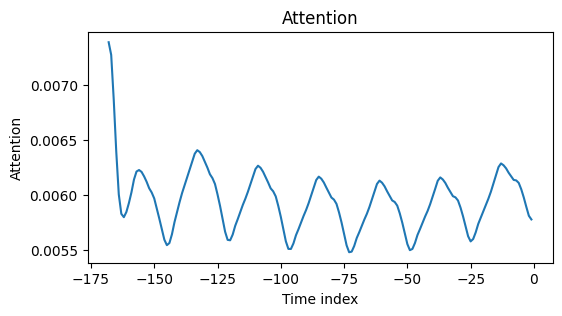

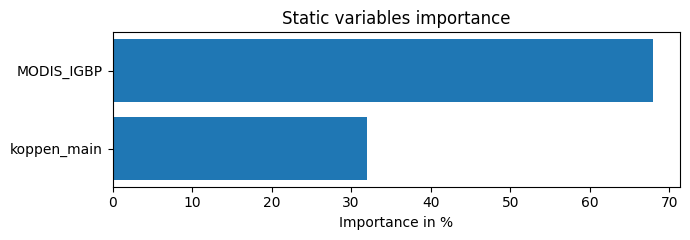

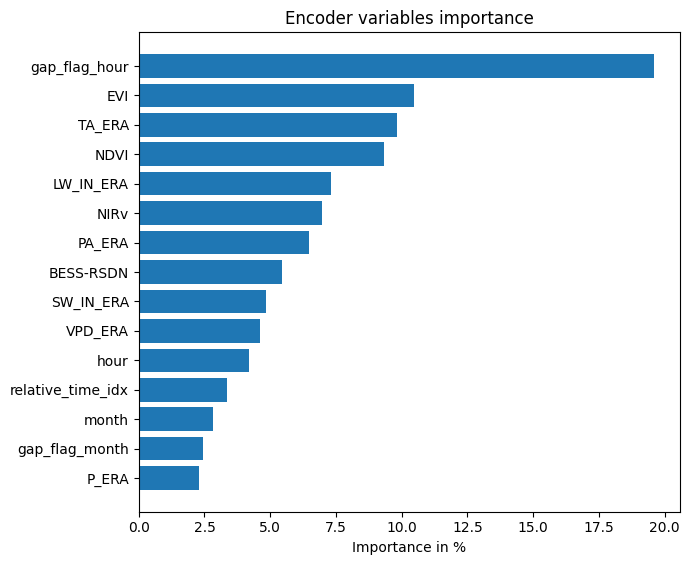

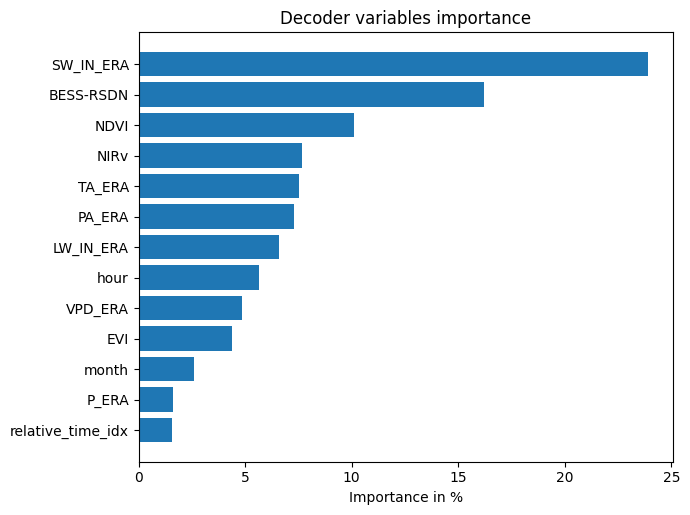

Site: AU-Emr


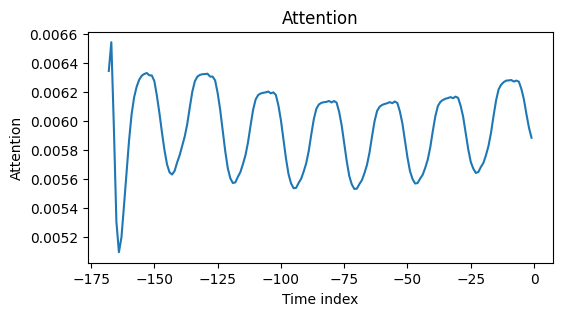

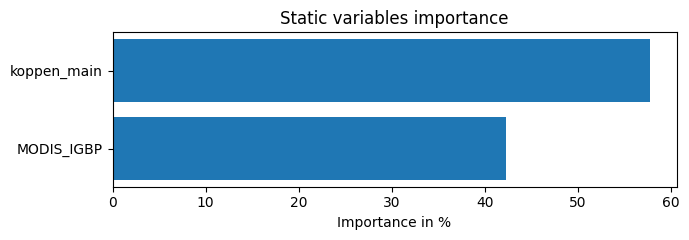

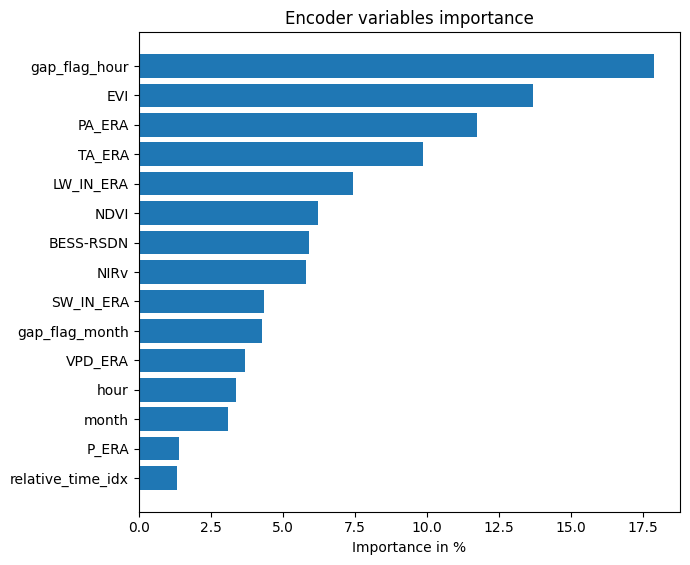

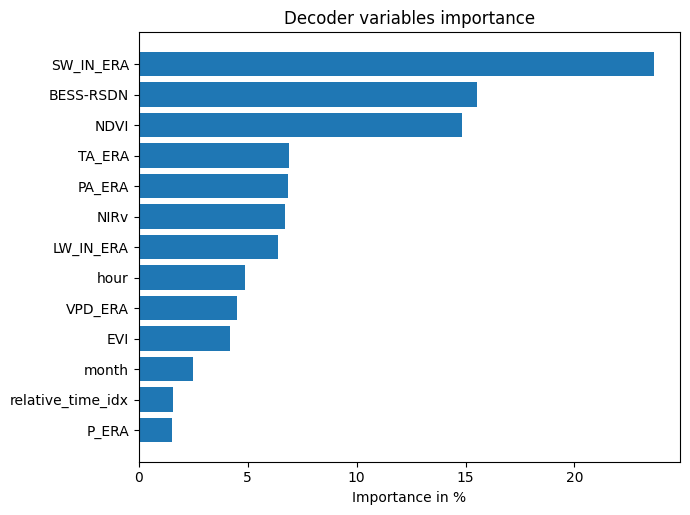

Site: AU-Gin


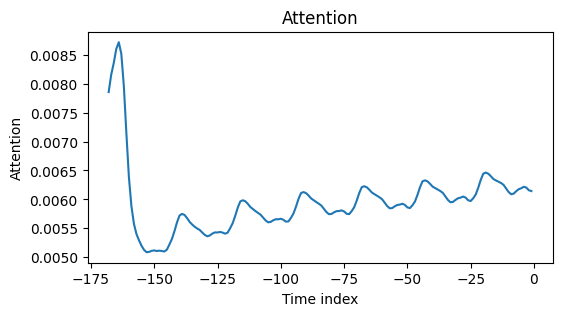

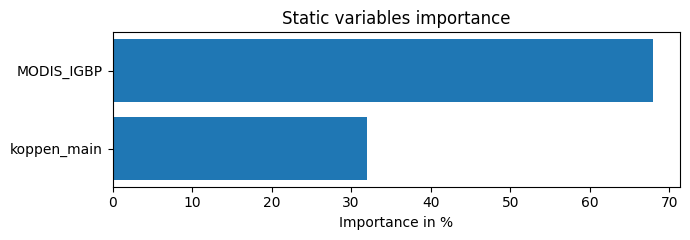

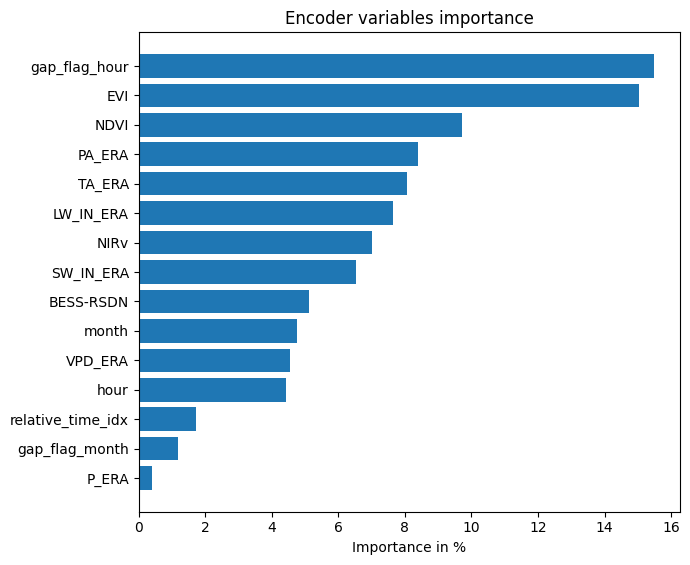

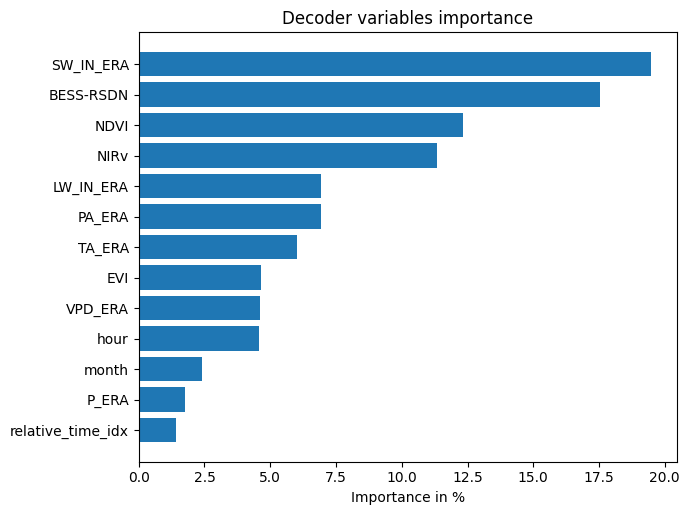

,site_id,month,hour,gap_flag_month,gap_flag_hour,TA_ERA,SW_IN_ERA,LW_IN_ERA,VPD_ERA,P_ERA,PA_ERA,EVI,NDVI,NIRv,BESS-RSDN,relative_time_idx
0,Average,0.03011,0.03660,0.06451,0.17843,0.09800,0.07457,0.05644,0.05134,0.05122,0.06304,0.11954,0.06280,0.04373,0.05006,0.01962
1,AU-DaP,0.02836,0.04183,0.02452,0.19607,0.09808,0.04856,0.07303,0.04600,0.02290,0.06481,0.10481,0.09324,0.06971,0.05464,0.03343
2,AU-Emr,0.03101,0.03369,0.04268,0.17880,0.09865,0.04352,0.07436,0.03700,0.01408,0.11734,0.13668,0.06212,0.05793,0.05897,0.01317
3,AU-Gin,0.04755,0.04440,0.01191,0.15482,0.08054,0.06534,0.07629,0.04539,0.00395,0.08390,0.15028,0.09711,0.07014,0.05118,0.01720


In [119]:
# Init Hour Feature Importance DF
site_fi_df = pd.DataFrame(columns= ['site_id'] + known_cat + unknown_cat + known_real + ['relative_time_idx'])
site_fi_df.loc[len(site_fi_df)] = avg_fi_vals

i = 0
val_sites = list(val_df['site_id'].unique())
for choose_site in val_sites:
    print(f"Site: {choose_site}")
    
    # Get preds for the given hour of day
    raw_prediction_site = best_tft.predict(
        validation.filter(lambda x: (x.site_id == choose_site)),
        mode="raw",
        return_x=False)
    
    # Interpret Outputs
    interpretation_sum = best_tft.interpret_output(raw_prediction_site, reduction="sum")
    best_tft.plot_interpretation(interpretation_sum)
    plt.show(block=False)
    
    # Append Feature Importances to DF
    site_fi_df = get_feature_imps_group(raw_prediction_site, site_fi_df, choose_site)
    
    # Temp break
    i += 1
    if i == 3:
        break
    
site_fi_df.head()

### Plot predictions by Hour of day

In [24]:
# Create a dataframe for the decoded index of validation dataloader
dec_ind_df = pd.DataFrame(validation.decoded_index)
dec_ind_df = pd.merge(dec_ind_df, val_df[['timestep_idx_global', 'hour']].drop_duplicates(), how='left', left_on='time_idx_first_prediction', right_on='timestep_idx_global')
dec_ind_df.head(3)

,site_id,time_idx_first,time_idx_last,time_idx_first_prediction,timestep_idx_global,hour
0,AU-DaP,350640,350808,350808,350808,0
1,AU-DaP,350641,350809,350809,350809,1
2,AU-DaP,350642,350810,350810,350810,2



 Hour: 1

 Hour: 12

 Hour: 16


,IGBP,month,hour,gap_flag_month,gap_flag_hour,TA_ERA,SW_IN_ERA,LW_IN_ERA,VPD_ERA,P_ERA,PA_ERA,EVI,NDVI,NIRv,BESS-RSDN,relative_time_idx
0,1,0.03010,0.03659,0.06450,0.17849,0.09799,0.07454,0.05643,0.05135,0.05122,0.06306,0.11953,0.06277,0.04373,0.05008,0.01962
1,12,0.03012,0.03661,0.06453,0.17846,0.09799,0.07460,0.05643,0.05133,0.05122,0.06300,0.11954,0.06281,0.04372,0.05001,0.01962
2,16,0.03014,0.03664,0.06456,0.17804,0.09806,0.07464,0.05645,0.05136,0.05121,0.06299,0.11957,0.06291,0.04373,0.05006,0.01963


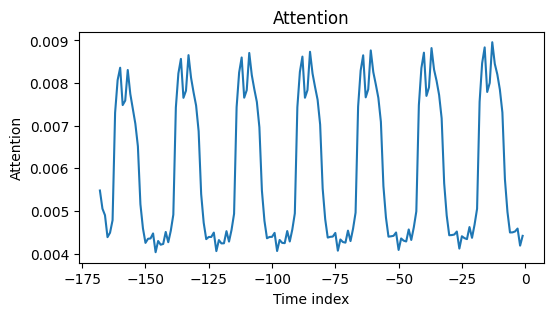

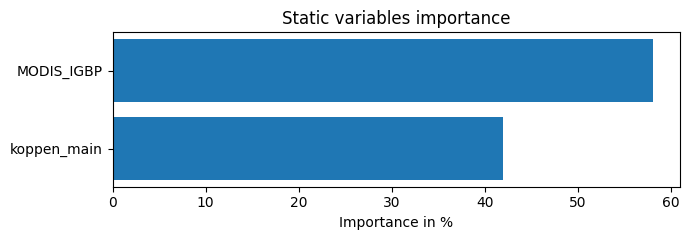

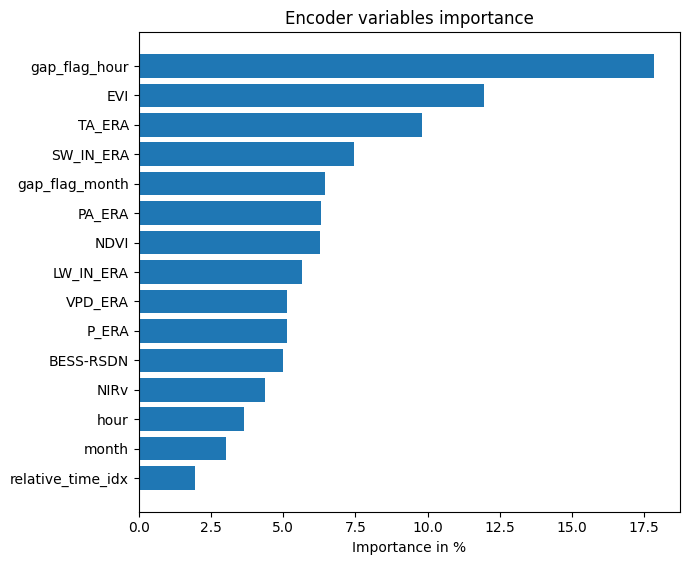

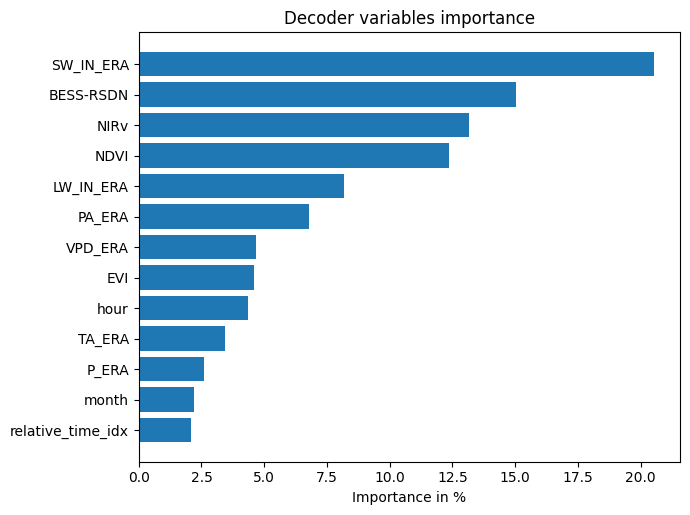

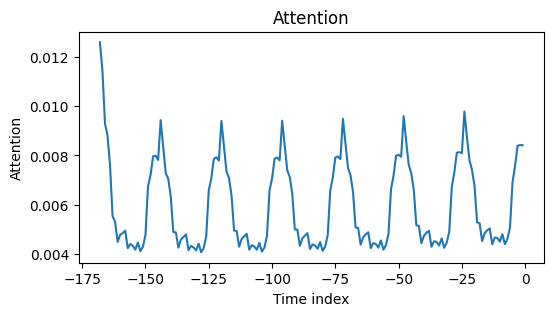

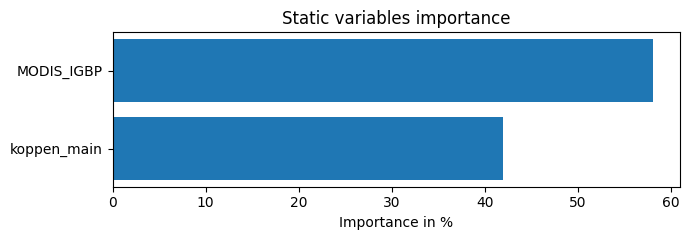

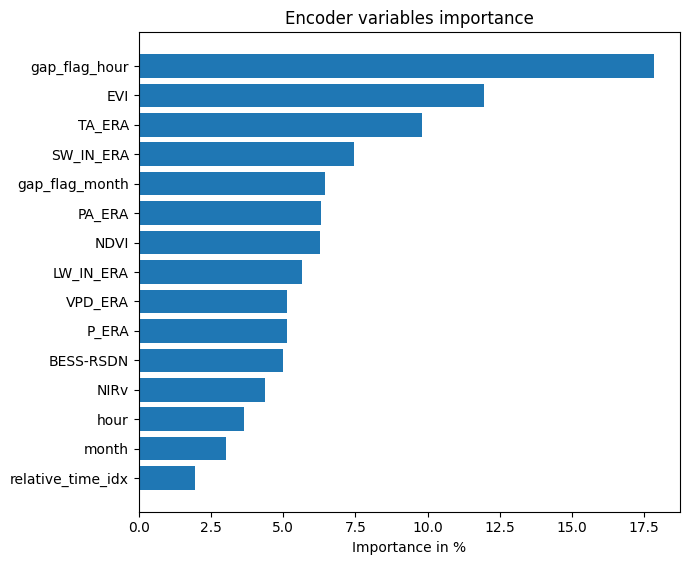

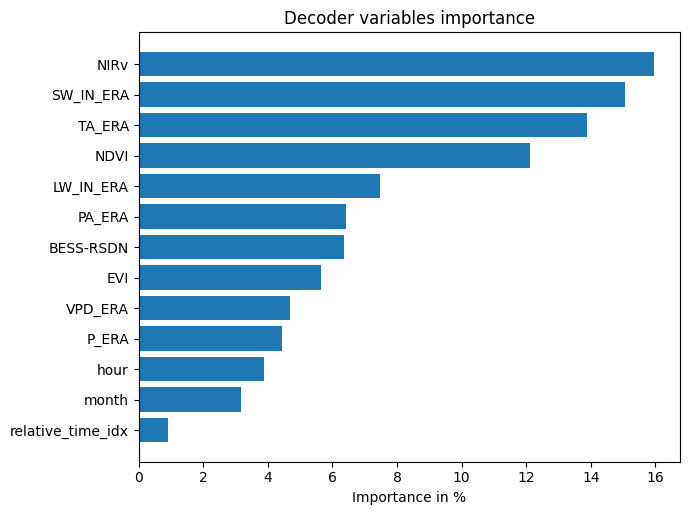

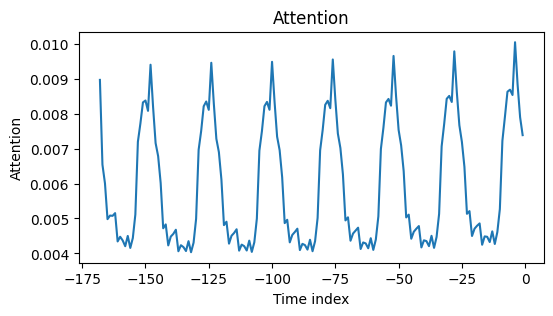

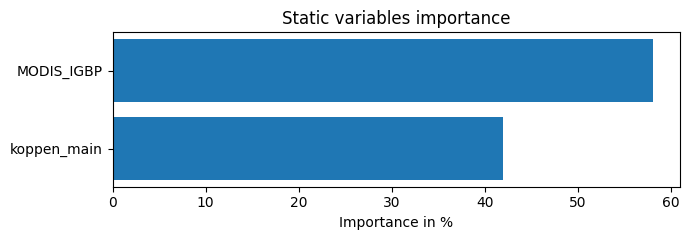

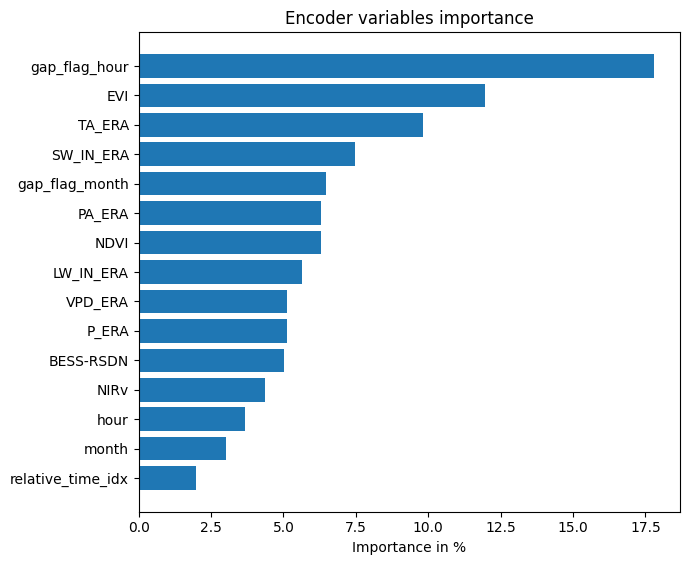

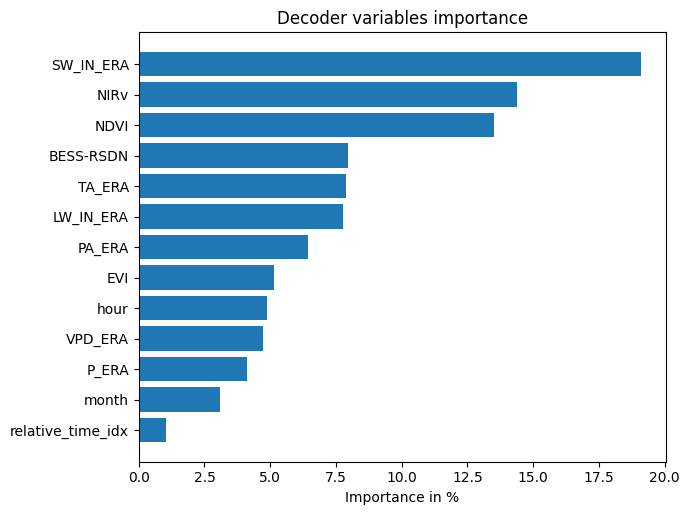

In [25]:
# Init Hour Feature Importance DF
hour_fi_df = pd.DataFrame(columns= ['hour_of_day_predicted'] + known_cat + unknown_cat + known_real + ['relative_time_idx'])

# Add avg importances to df
hour_fi_df.loc[len(hour_fi_df)] = avg_fi_vals

i = 0
for choose_hour in ['1', '12', '16', '18']:
    print(f"\n Hour: {choose_hour}")
    # Get timesteps for the hour
    hour_timesteps = dec_ind_df.loc[dec_ind_df['hour']==choose_hour, 'time_idx_first_prediction'].values
    
    # Get preds for the given hour of day
    raw_prediction_hour = best_tft.predict(
        validation.filter(lambda x: (x.time_idx_first_prediction.isin(hour_timesteps))),
        mode="raw",
        return_x=False)
    
    # Interpret Outputs
    interpretation_sum = best_tft.interpret_output(raw_prediction_hour, reduction="sum")
    best_tft.plot_interpretation(interpretation_sum)
    
    # Append Feature Importances to DF
    hour_fi_df = get_feature_imps_group(raw_prediction_hour, hour_fi_df, choose_hour)
    
    # Temp break for testing
    i += 1
    if i == 3:
        break
        
hour_fi_df.head()

## Prediction-Level Attention and Feature Importance
To-Do: Find specific timesteps to tell a story

In [151]:
interpretation_none = best_tft.interpret_output(raw_predictions, reduction="none")

In [152]:
# Determine which features align to "encoder_variables", validate against imoprtances above
enc_var_means = torch.mean(interpretation_none['encoder_variables'], dim=0).numpy()
enc_var_names = known_cat + unknown_cat + known_real + ['relative_time_idx']
feature_imp_dict = dict(zip(enc_var_names, enc_var_means))
feature_imp_dict

{'month': 0.047419373,
 'hour': 0.0672771,
 'gap_flag_month': 0.033083137,
 'gap_flag_hour': 0.19209804,
 'TA_ERA': 0.120516814,
 'SW_IN_ERA': 0.062383708,
 'LW_IN_ERA': 0.027075365,
 'VPD_ERA': 0.064754,
 'P_ERA': 0.022391964,
 'PA_ERA': 0.05328697,
 'EVI': 0.09732815,
 'NDVI': 0.08495531,
 'NIRv': 0.067507215,
 'BESS-RSDN': 0.049364902,
 'relative_time_idx': 0.010557951}

### Investigate feature importances for 1 prediction

In [155]:
# Get top timestep for pred 1
pred_ind = 0
ind = raw_predictions["encoder_attention"][pred_ind][0][0].argmax()
print(f"Top encoder attention index is for pred {pred_ind} is {ind-ENCODER_LEN}")

# Which feature is most important at this prediction step?
enc_vars_at_ind = raw_predictions["encoder_variables"][pred_ind][ind]
enc_ind = torch.argmax(enc_vars_at_ind)
feat_ind = enc_var_names[enc_ind]
print(f"Most important feature at index {ind-ENCODER_LEN} is {feat_ind}")

Top encoder attention index is for pred 0 is -36
Most important feature at index -36 is NDVI


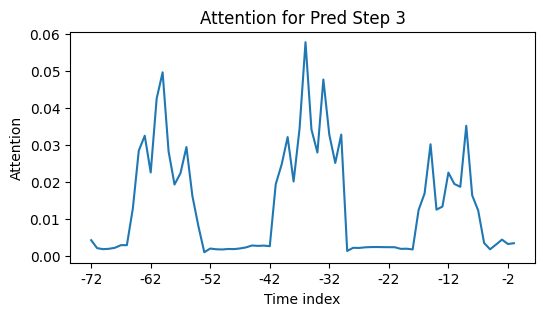

In [156]:
# attention
fig, ax = plt.subplots()
attention = interpretation_none["attention"][pred_ind].detach().cpu()
attention = attention / attention.sum(-1).unsqueeze(-1)
ax.plot(attention)
ax.set_xlabel("Time index")
ax.set_ylabel("Attention")
ax.set_title(f"Attention for Pred Step {i}")
xticks_locations = range(0, len(attention), 10)
xticks_labels = range(-len(attention), 0, 10)
plt.xticks(xticks_locations, xticks_labels)
plt.show()

In [157]:
# Pick one step, find the highest attention timestep, find 
pred_feat_importances = torch.mean(raw_predictions["encoder_variables"][pred_ind], dim=0)[0].numpy()

print(f"Prediction-Level Feature Importances at Pred Step {pred_ind}, across all encoder inds")
pred_feature_imp_dict = dict(zip(enc_var_names, pred_feat_importances))
sorted_dict = dict(sorted(pred_feature_imp_dict.items(), key=lambda item: item[1], reverse=True))
print(sorted_dict)

Prediction-Level Feature Importances at Pred Step 0, across all encoder inds
{'gap_flag_hour': 0.19956596, 'SW_IN_ERA': 0.17962879, 'NDVI': 0.1036113, 'BESS-RSDN': 0.08509452, 'NIRv': 0.0745492, 'hour': 0.06805203, 'VPD_ERA': 0.060291395, 'month': 0.05624755, 'TA_ERA': 0.04564881, 'PA_ERA': 0.045528546, 'gap_flag_month': 0.028593242, 'LW_IN_ERA': 0.020662371, 'P_ERA': 0.011690492, 'EVI': 0.010603456, 'relative_time_idx': 0.0102322865}


## Investigate Attention Curve Peaks, Valleys

{'attention': <Figure size 600x300 with 1 Axes>,
 'static_variables': <Figure size 700x250 with 1 Axes>,
 'encoder_variables': <Figure size 700x575 with 1 Axes>,
 'decoder_variables': <Figure size 700x525 with 1 Axes>}

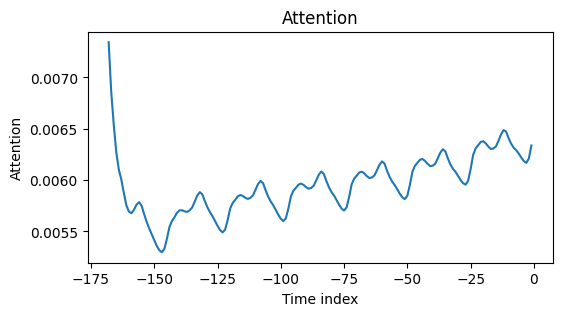

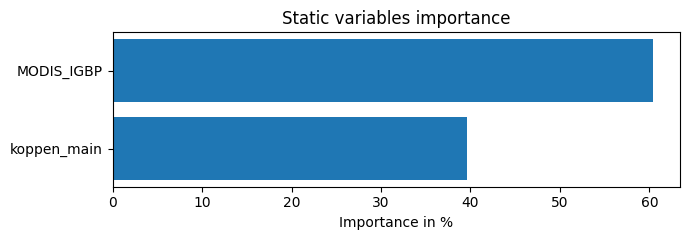

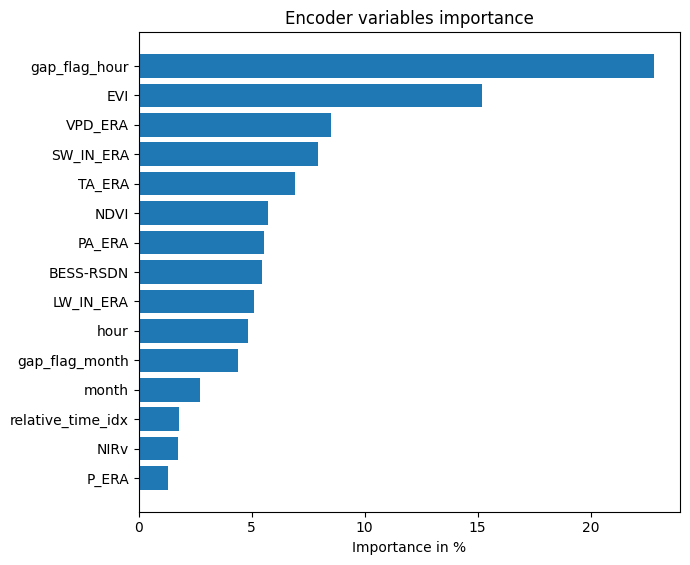

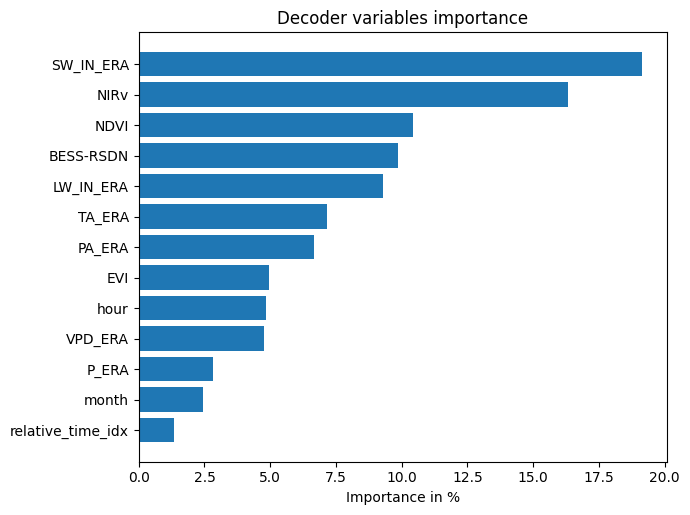

In [38]:
# Subset val_df
igbp_dbf = val_df.loc[val_df['IGBP']=='DBF', ].copy()

# Get dataloader and then predictions
_, val_igbp, _ = setup_tsdataset_nogpp_slim(train_df, igbp_dbf, None, ENCODER_LEN)
raw_prediction_igbp = best_tft.predict(val_igbp, mode="raw", return_x=False, show_progress_bar=False)

# Interpret Outputs
interpretation_sum = best_tft.interpret_output(raw_prediction_igbp, reduction="sum")
best_tft.plot_interpretation(interpretation_sum)

In [82]:
# Init df
example_fi_df = pd.DataFrame(columns= ['encoder_timestep'] + known_cat + unknown_cat + known_real + ['relative_time_idx'])

# Add avg importances to df
avg_fi_vals = torch.mean(torch.mean(raw_predictions["encoder_variables"].squeeze(), dim=0), dim=0).numpy()
example_fi_df.loc[len(example_fi_df)] = ['Average'] + list(avg_fi_vals)

# Get FIs at each step
for time in range(ENCODER_LEN):
    feature_means_time = torch.mean(raw_predictions["encoder_variables"].squeeze(), dim=0)[time].numpy()
    neg_time = time-ENCODER_LEN
    example_fi_df.loc[len(example_fi_df)] = [neg_time] + list(feature_means_time)

# Merge in attn vales
attn_time = torch.mean(raw_predictions["encoder_attention"].squeeze().squeeze(), dim=0)
example_fi_df['attn_time'] = [np.nan] + list(attn_time.numpy())

In [89]:
#!conda install jinja2 -y

In [122]:
# Save out
example_fi_df.to_csv(root_dir + os.sep + 'data/feature_imp_by_time_igbp_dbp.csv', index=False)

# Display
example_fi_df.sort_values('attn_time', ascending=False, inplace=True)
styled_df = example_fi_df.style.background_gradient(cmap='Greens')
styled_df

,encoder_timestep,month,hour,gap_flag_month,gap_flag_hour,TA_ERA,SW_IN_ERA,LW_IN_ERA,VPD_ERA,P_ERA,PA_ERA,EVI,NDVI,NIRv,BESS-RSDN,relative_time_idx,attn_time
1,-168.000000,0.030036,0.036695,0.063241,0.167284,0.101029,0.073588,0.058847,0.052201,0.051972,0.067458,0.122949,0.063858,0.045015,0.047376,0.018450,0.007589
2,-167.000000,0.030037,0.036694,0.063259,0.167420,0.100997,0.073601,0.058818,0.052191,0.051964,0.067401,0.122911,0.063845,0.044997,0.047405,0.018460,0.007306
3,-166.000000,0.030038,0.036694,0.063276,0.167557,0.100965,0.073613,0.058789,0.052180,0.051956,0.067344,0.122872,0.063832,0.044980,0.047433,0.018471,0.006843
4,-165.000000,0.030039,0.036693,0.063293,0.167693,0.100933,0.073626,0.058760,0.052170,0.051947,0.067287,0.122833,0.063819,0.044963,0.047462,0.018481,0.006437
157,-12.000000,0.030173,0.036469,0.065472,0.187805,0.095114,0.075361,0.054351,0.050591,0.050503,0.059494,0.116493,0.061924,0.042737,0.052620,0.020895,0.006197
158,-11.000000,0.030173,0.036466,0.065483,0.187929,0.095070,0.075371,0.054323,0.050581,0.050492,0.059448,0.116449,0.061913,0.042725,0.052659,0.020917,0.006188
156,-13.000000,0.030172,0.036471,0.065461,0.187681,0.095157,0.075350,0.054380,0.050601,0.050514,0.059539,0.116536,0.061935,0.042749,0.052580,0.020874,0.006175
168,-1.000000,0.030181,0.036440,0.065592,0.189151,0.094633,0.075472,0.054037,0.050478,0.050382,0.059008,0.116017,0.061803,0.042609,0.053056,0.021141,0.006157
159,-10.000000,0.030174,0.036463,0.065494,0.188053,0.095027,0.075381,0.054294,0.050570,0.050481,0.059403,0.116406,0.061903,0.042713,0.052698,0.020939,0.006154
5,-164.000000,0.030040,0.036693,0.063311,0.167829,0.100901,0.073638,0.058731,0.052160,0.051939,0.067230,0.122794,0.063806,0.044945,0.047491,0.018492,0.006143
